# Homework 8: Autoencoders

Groupmembers:
- Carmen Amme (994813)
- Anneke Büürma (995025)
- Wilfred Okajevo (998818)


### Import Libraries and Modules

In [1]:
# load packages
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers,losses
from tensorflow.keras.models import Model
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

### Load Dataset and initial visualization

In [2]:
# load dataset
(x_train_ds, _), (x_test_ds, _) = mnist.load_data()
print(x_train_ds.shape,x_test_ds.shape)

x_train_ds_1000 = x_train_ds[0:1000]
print(x_train_ds_1000.shape)

11490434/11490434 [==============================] - 2s 0us/step
(60000, 28, 28) (10000, 28, 28)
(1000, 28, 28)


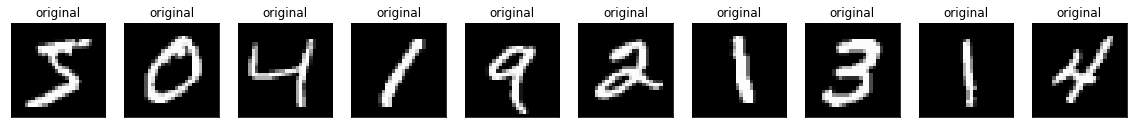

In [3]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  
  plt.imshow(x_train_ds[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

### Preprocessing

In [4]:
def preprocessing(ds, noise_level, batchsize, return_noisy=False):
  
  #change datatype from uint8 to tf.float values and normalize
  
  ds = ds.reshape((ds.shape[0], 28, 28, 1))
  ds = ds.astype('float32') / 255.
  #add dimension
  ds = tf.expand_dims(ds, -1)

  #make tuple
  target = tf.identity(ds)

  #add noise
  noisy_images = ds + noise_level * tf.random.normal(shape=ds.shape)
  noisy_images = tf.clip_by_value(noisy_images, clip_value_min=0., clip_value_max=1.)

  ds_tuple = (noisy_images, target)

  # shuffle, batch, prefetch
  # ds_tuple = tf.random.shuffle(ds_tuple)
  # ds_tuple = ds_tuple.map(lambda inp, y: tf.data.Dataset.zip((inp.batch(7), y.batch(7))))
  ds_tuple = tf.data.Dataset.from_tensor_slices(ds_tuple).shuffle(ds.shape[0]).batch(batchsize)
  ds_tuple = ds_tuple.prefetch(tf.data.AUTOTUNE)

  if return_noisy:
    return noisy_images, ds_tuple
  else:
    return ds_tuple

In [5]:
ds_train = preprocessing(x_train_ds, 0.3, 32)
ds_test = preprocessing(x_test_ds,0.3,32)

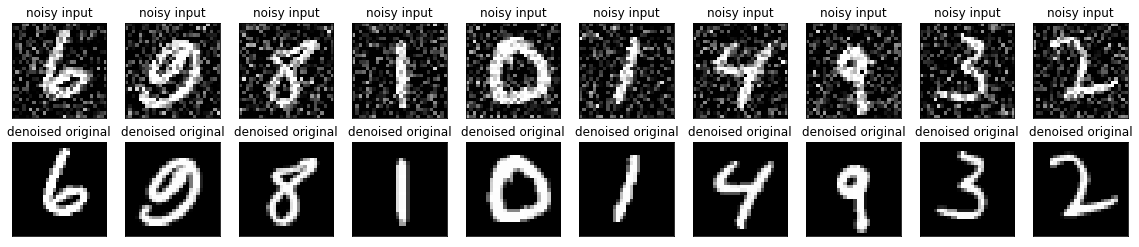

In [6]:
# visualize some images with corresponding labels
n = 10
plt.figure(figsize=(20, 4))
i=0
for input,target in ds_train:
  if i==n:
    break
  
  # display original
  ax = plt.subplot(2, n, i + 1)
  
  plt.imshow(tf.squeeze(input[i]))
  plt.title("noisy input")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(tf.squeeze(target[i]))
  plt.title("denoised original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  i += 1

plt.show()

### The Model

ConvolutionAutoencoder

In [7]:
class ConvolutionAutoencoder(Model):
  def __init__(self):
    super(ConvolutionAutoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2),
      layers.Flatten(),
      layers.Dense(10),
      ])
    
    self.decoder = tf.keras.Sequential([
      layers.Input(shape=(10,)),
      layers.Dense(units=7*7*32, activation=tf.nn.relu),
      tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = ConvolutionAutoencoder()

In [8]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=losses.MeanSquaredError(), 
                    metrics=['accuracy'])



In [ ]:
autoencoder.decoder.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1568)              17248     
                                                                 
 reshape (Reshape)           (None, 7, 7, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        2312      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 20,873
Trainable params: 20,873
Non-trai

### Training

In [9]:
# save logs with Tensorboard
EXPERIMENT_NAME = "autoencoder"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logging_callback = tf.keras.callbacks.TensorBoard(log_dir=f".myModel/{EXPERIMENT_NAME}/{current_time}")

epochs=10
history = autoencoder.fit(ds_train,
                epochs=epochs,
                shuffle=True,
                validation_data=ds_test)



# mymodel.load_weights(checkpoint_filepath)

Epoch 1/10
1875/1875 [==============================] - 18s 5ms/step - loss: 0.0410 - accuracy: 0.8054 - val_loss: 0.0228 - val_accuracy: 0.8070
Epoch 2/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.0216 - accuracy: 0.8081 - val_loss: 0.0200 - val_accuracy: 0.8079
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0198 - accuracy: 0.8091 - val_loss: 0.0188 - val_accuracy: 0.8085
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0189 - accuracy: 0.8097 - val_loss: 0.0184 - val_accuracy: 0.8085
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0183 - accuracy: 0.8100 - val_loss: 0.0178 - val_accuracy: 0.8092
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0180 - accuracy: 0.8102 - val_loss: 0.0175 - val_accuracy: 0.8096
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0177 - accuracy: 0.8103 - val_loss: 0.0173 - val_accurac

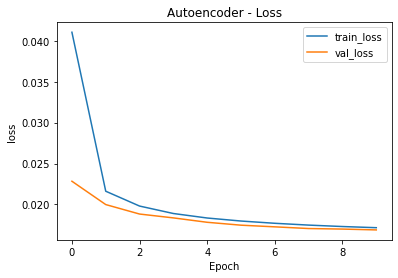

In [10]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
#plt.plot(history.history["MAE"])
#plt.plot(history.history["val_MAE"])
plt.legend(labels=["train_loss","val_loss", "train_acc", "val_acc"])
plt.title('Autoencoder - Loss')
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.savefig(f"testing: e={epochs}")
plt.show()

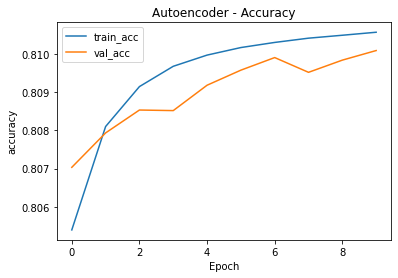

In [11]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(labels=["train_acc", "val_acc"])
plt.title('Autoencoder - Accuracy')
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.savefig(f"testing: e={epochs}")
plt.show()

##### Visualize Results on test data

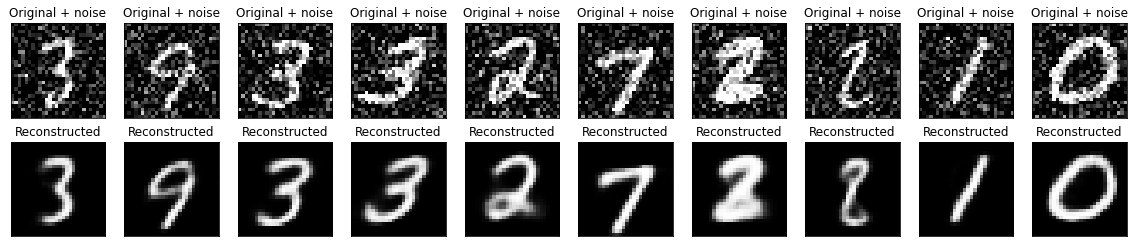

In [12]:
# visualize some images with corresponding labels
n = 10
plt.figure(figsize=(20, 4))
i=0

for input,_ in ds_test:
  encoded_img = autoencoder.encoder(input).numpy()
  decoded_img = autoencoder.decoder(encoded_img).numpy()
# for input,target in ds_train:
  if i==n:
    break
  
  # display original
  ax = plt.subplot(2, n, i + 1)
  
  plt.imshow(tf.squeeze(input[i]))
  plt.title("Original + noise")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(tf.squeeze(decoded_img[i]))
  plt.title("Reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  i += 1

plt.show()

## Latent Space Analysis

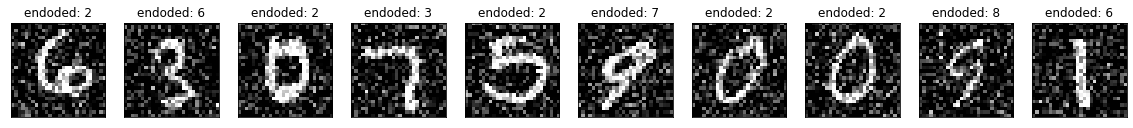

In [13]:
# visualize some images with corresponding labels
n = 10
plt.figure(figsize=(20, 4))
i=0

for input,_ in ds_test:
  encoded_img = autoencoder.encoder(input).numpy()
  t = np.argmax(encoded_img, axis=1)
  decoded_img = autoencoder.decoder(encoded_img).numpy()
# for input,target in ds_train:
  if i==n:
    break
  
  # display original
  ax = plt.subplot(2, n, i + 1)
  
  plt.imshow(tf.squeeze(input[i]))
  plt.title(f'endoded: {t[i]}')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  i += 1
plt.show()

In [14]:
noisy, ds_train_1000 = preprocessing(x_train_ds_1000, 0.3, 32, True)

In [15]:
noisy = tf.reshape(noisy, [1000, 784]) #[rows, columns]
noisy.shape

TensorShape([1000, 784])

In [16]:
all_t = list()
for input,_ in ds_train_1000:
  encoded_img = autoencoder.encoder(input).numpy()
  t = np.argmax(encoded_img, axis=1)
  all_t.append(t.tolist())
all_t = [item for sublist in all_t for item in sublist]

In [17]:
embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(noisy)

In [18]:
# create dataframe
value1 = list()
value2 = list()
for i in range(len(embedded)):
  value1.append(embedded[i][0])
  value2.append(embedded[i][1])
embed_df = pd.DataFrame({'value1':value1, 'value2': value2, 'target': all_t})

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


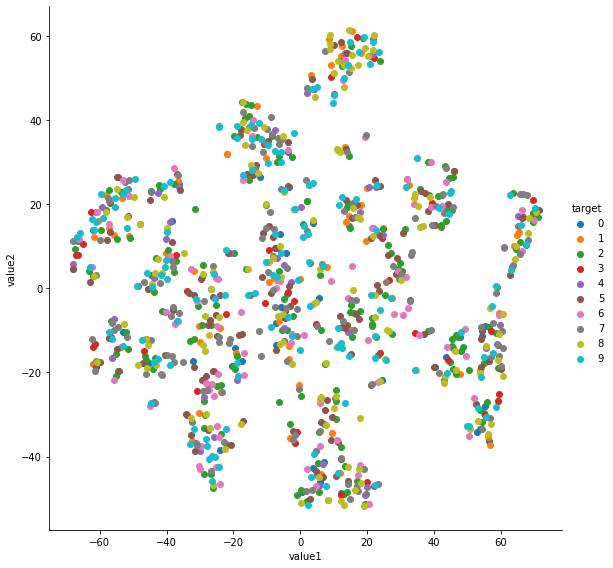

In [19]:
grid = sns.FacetGrid(embed_df, size=8, hue='target')
grid.map(plt.scatter, 'value1', 'value2').add_legend()

This is not what we expected, maybe we did something wrong somewhere. We cant find the issue. But we would expect it to be more clustered -> one cloud for each digit.

## Variational AutoEncoder

In [ ]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [ ]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits


optimizer = tf.keras.optimizers.Adam(0.001)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.expand_dims(tf.squeeze(x_logit),axis=-1), labels=tf.expand_dims(tf.squeeze(x),axis=-1))
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
epochs = 2
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [ ]:
def generate_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  plt.show()

In [ ]:
# Pick a sample of the test set for generating output images
batchsize = 32
assert batchsize >= num_examples_to_generate
for test_batch,_ in ds_test:
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 2, Test set ELBO: -361.1571350097656, time elapse for current epoch: 5.265566110610962


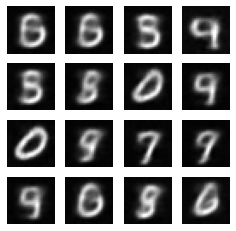

In [ ]:
generate_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x,_ in ds_train:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x,_ in ds_test:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_images(model, epoch, test_sample)